# Estimating Seats-Votes Curves using a Bootstrap approach

*Levi John Wolf<br>
University of Bristol<br>
levi.john.wolf@gmail.com<br>
(Supported by NSF #1657689)*

As we have seen in previous discussions of bias measures & seats-votes curves, it's sometimes helpful to have a method to replicate/simulate additional elections that look *somewhat* like those we did observe, but also involve some kind of small adjustment or marginal change to the values involved in the problem. Having these simulated elections allows us to estimate the values of partisan bias (or, any other relevant electoral statistic) for the *entire set* of simulated elections, in addition to the one that was observed. If these simulations are constructed in a way that meaningfully models a scenario under study, then analyzing the simulations provides a model of the intrinsic variability in the estimate of partisan bias. Thus, these elections simulators are useful in providing a rough estimate of the intrinsic variability in our estimates about the electoral system. 

In general, the simulators implemented in the `seatsvotes` package aim to replicate or extend existing work. However, two of the simplest simulators are novel, and deserve explanation separately from the replication of Gelman & King (1994), Linzer (2012), or McGann et al. (2015). Thus, I will first explain & discuss the *Bootstrap* simulator used in the previous 4 chapters. I'll discuss this in depth.

First, though, we need to import some packages useful for visualizing electoral data:

In [1]:
import pandas
import numpy
import seaborn
import seatsvotes
import matplotlib.pyplot as plt
%matplotlib inline

Then, we'll use the built-in example dataset for the `seatsvotes` package:

In [2]:
house = seatsvotes.data.congress(geo=True)
house = house.query('year in (2006,2008)')

The bootstrap simulator works by 
1. shuffling the change in vote from last year to this year
2. applying the shuffled changes back to last year to build a "new" this year.

Formally, with two elections in time $t$ and time $t-1$, a *swing* vector is built as:

$$ \delta = v_t - v_{t-1}$$

Then, a new hypothetical election in time $t$ is built by *shuffling* $\delta$ to make $\tilde \delta$, and:

$$ v_{t-1} + \tilde{\delta} = v_t' $$

If $\delta$ weren't shuffled, $v_t' = v_t$, since we'd just apply the change in vote between $v_{t-1}$ and $v_{t}$ *back to* $v_{t-1}$. However, since we shuffle $\delta$, we obtain elections that, on average, look like $v_t$, but at any specific $v_t'$, may look quite different from the observed outcome $v_t$. 

Theoretically, this shuffling ensures that any structural or ephemeral advantages experienced by legislators (such as candidate quality, incumbency, race, down-ballot effects, or weather effects) propagate into the simulated elections. The *change* in vote shares from year to year includes both the intrinsic random factors and the structural factors relating candidates. However, in the best case, the same candidate runs for reelection in the same district. When this occurs, the *structural* factors relating to the candidate are unlikely to change; the same candidate is running, so their personal structural advantage or disadvantage do not necessarily change a large amount. 

Sometimes, of course, they do: 

- a candidate may win an election in time $t-1$ and then run for re-election in period $t$ unopposed 
- a candidate may experience strong presidential coattails in time $t-1$ and then face stiff midterm opposition by high-quality challengers in time $t$

However, many of the factors that do tend to be relevant for electoral analysis are held constant, and (as we discussed) elections tend to (on average) look like the observed $v_t$. 

Showing how this works, let's first just use the estimator to structure the data & prepare it for analysis:

In [3]:
house.head()

,index,congress,year,delsouth,state_fips,contest_ui,inc,king_dist,lewis_dist,state_name,turnout,vote_share,geom_uid,geometry
1740,8257,110,2006,1,12,110012021,-1,NaN,21,florida,112306.0,0.405339,012108112021,POLYGON ((-80.30847300000001 25.77737699999997...
1741,8258,110,2006,1,05,110005003,-1,NaN,3,arkansas,200924.0,0.377680,005108112003,POLYGON ((-94.43377207885037 35.31490172478177...
1742,8259,110,2006,1,12,110012017,1,NaN,17,florida,90663.0,1.000000,012108112017,"POLYGON ((-80.184569 25.84757400000002, -80.18..."
1743,8260,110,2006,1,12,110012018,-1,NaN,18,florida,128130.0,0.378514,012108112018,"(POLYGON ((-80.312274 25.638081, -80.312174 25..."
1744,8261,110,2006,1,12,110012020,1,NaN,20,florida,NaN,1.000000,012108112020,"(POLYGON ((-80.214769 26.04646699999997, -80.2..."


In [4]:
house['district_id'] = house.contest_ui.apply(lambda x: x[3:])

In [5]:
bootstrapper = seatsvotes.Bootstrap(house, 
                                    uncontested='ignore',
                                    district_id='district_id')

/home/lw17329/Dropbox/dissert/dev/seatsvotes/seatsvotes/utils.py:143: UserWarning: computing redistricting from years vector
  warn('computing redistricting from years vector')
/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Before we simulate elections, let's inspect the data used to build the bootstrapper. For most classes in `seatsvotes`, a "wide" representation of the electoral data is built automatically. The `wide` attribute, then, is a list of each year's elections frame, including the previous year's voteshares (if no redistricting occurs). This is formed by partially pivoting the table to ensure that each year's dataframe has last year's vote shares, too. 

This is mainly useful, though, for the analysis of the vote share dataframes directly:

In [8]:
bootstrapper.wide[-1].head()

,index,congress,year,delsouth,state_fips,contest_ui,inc,king_dist,lewis_dist,state_name,turnout,vote_share,geom_uid,geometry,district_id,weight,uncontested,redist,vote_share__prev
0,13914,111,2008,1,12,111012021,-1,NaN,21,florida,237002.0,0.420992,012108112021,POLYGON ((-80.30847300000001 25.77737699999997...,012021,1,0,0,0.405339
1,13915,111,2008,1,05,111005003,-1,NaN,3,arkansas,215196.0,0.000000,005108112003,POLYGON ((-94.43377207885037 35.31490172478177...,005003,1,-1,0,0.377680
2,13916,111,2008,1,12,111012017,1,NaN,17,florida,NaN,1.000000,012108112017,"POLYGON ((-80.184569 25.84757400000002, -80.18...",012017,1,1,0,1.000000
3,13917,111,2008,1,12,111012018,-1,NaN,18,florida,242989.0,0.421303,012108112018,"(POLYGON ((-80.312274 25.638081, -80.312174 25...",012018,1,0,0,0.378514
4,13918,111,2008,1,12,111012020,1,NaN,20,florida,202832.0,1.000000,012108112020,"(POLYGON ((-80.214769 26.04646699999997, -80.2...",012020,1,1,0,1.000000


Looking specifically at the vote shares in 2008, 

In [13]:
v08 = bootstrapper.wide[-1]

we can see that the distribution of vote shares is shown below:

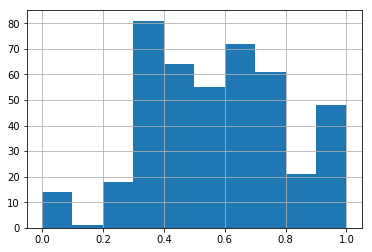

In [12]:
v08.vote_share.hist()

Since each district has the vote shares won in 2006 and in 2008, we can get the *swings* experienced by districts from 2006 to 2008 as well:

In [14]:
v08['swing'] = v08.vote_share - v08.vote_share__prev

With the swing, we can construct many different alternative elections in 2008:

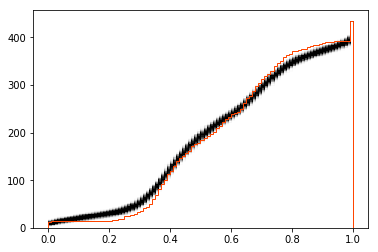

In [29]:
for _ in range(1000):
    shuffled_swing = v08.swing.sample(frac=1, replace=False).values
    
    simulation = numpy.clip(shuffled_swing + v08.vote_share__prev, 0,1)
    
    plt.hist(simulation, color='k', histtype='step', alpha=.01, bins=100, cumulative=True)
plt.hist(v08.vote_share.values, color='orangered', histtype='step', bins=100, cumulative=True)
plt.show()

In general, this means that there are more *bootstrapped* elections between 0 & (about) 30% average Democrat vote share, and fewer comparatively with shares from around 75% to 95% Democrat vote share. The overrepresentation in this range is mainly composed of uncontested districts in 2006 that get randomly assigned a small swing that was observed for a competitive district near the center of the vote distribution. Overall, this means that the bootstrapping method in this case tends to overstate the "weakly contested" Republican districts & understate the "weakly contested" Democrat districts. Further, looking closely, the simulations are *slightly* more gentle for the districts in the middle of the cumulative distribution. 